In [54]:
import pandas as pd
import re
import string

# %pip install nltk

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt

import pickle


# Preprocessing Functions

## Data cleaning: strip, lower, digit, punctuation

In [ ]:
def basic_cleaning(texte):
    # stripping:
    data['text'] = data['text'].str.strip()

    # tolower:
    data['text'] = data['text'].str.lower()

    # digit: Remove digits from each row of the ‘text’ column
    data['text'] = data['text'].apply(lambda x: ''.join(char for char in x if not char.isdigit()))

    # punctuation: Remove all punctuation marks from the ‘text’ column
    data['text'] = data['text'].str.replace(r'[{}]'.format(re.escape(string.punctuation)), '', regex=True)

    # delete html-tags
    data['text'] = data['text'].apply(lambda x: re.sub('<[^<]+?>', '', x))

    return data['text']

## Data cleaning: tokenizing, stopwords, lemmatize

In [6]:
stop_words = set(stopwords.words('english'))

# Tokenise and remove stop words
def delete_stop_words(text):
    return [word for word in text if word.lower() not in stop_words and word not in string.punctuation]

# apply Lemmatization-Funktion
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    # Verben lemmatisieren
    verb_lemmatized = [lemmatizer.lemmatize(word, pos="v") for word in text]
    # Nomen lemmatisieren
    return [lemmatizer.lemmatize(word, pos="n") for word in verb_lemmatized]

# NLP-Cleaningfunktion
def nlp_cleaning(texte):
    # Tokenisation
    texte = texte.apply(word_tokenize)
    # Remove stop words
    texte = texte.apply(delete_stop_words)
    # Lemmatisation
    texte = texte.apply(lemmatize_text)
    # Combine words into a string
    return texte.apply(lambda x: ' '.join(x))

# RNN Model (Recurrent Neural Networks)

### Load and Preprocess Data

In [7]:
# Load the data
data = pd.read_csv('../raw_data/WELFake_Dataset.csv')

In [8]:
# Fill missing values with spaces
data = data.fillna(' ')

In [9]:
# Combine 'title' and 'text' columns, then drop 'title' column
data['text'] = data['title'] + ' ' + data['text']
data.drop('title', axis=1, inplace=True)

In [10]:
# Apply basic cleaning and NLP cleaning to the 'text' column
data['text'] = basic_cleaning(data['text'])
data['text'] = nlp_cleaning(data['text'])

In [11]:
# Remove duplicate rows
data.drop_duplicates(inplace=True)


In [12]:
# Shuffle the dataframe to ensure randomness
data = data.sample(frac=1, random_state=42)

In [13]:
# Separate features and labels
X = data['text']
y = data['label']

### Tokenize and Pad Sequences

In [39]:
# Word count for each entry in the 'text' column
data['word_count'] = data['text'].apply(lambda x: len(x.split()))

In [40]:
data['word_count'].describe()

count    72134.000000
mean       324.460712
std        363.685469
min          1.000000
25%        142.000000
50%        240.000000
75%        399.000000
max      20915.000000
Name: word_count, dtype: float64

In [14]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

# Pad sequences to ensure uniform input length
X_padded = pad_sequences(X_seq, maxlen=500)

### Train-Test Split

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.3, random_state=42)

### Simple RNN Model

In [31]:
# Instantiate model
rnn_model_1 = Sequential()
# Add an embedding layer to convert words to dense vectors
rnn_model_1.add(Embedding(input_dim=5000, output_dim=128))
# Add a simple RNN layer
rnn_model_1.add(SimpleRNN(units=128, return_sequences=False))
# Add a dropout layer to prevent overfitting
rnn_model_1.add(Dropout(rate=0.2))
# Add a dense output layer with sigmoid activation for binary classification
rnn_model_1.add(Dense(units=1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary cross-entropy loss
rnn_model_1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

### Train the Model

In [48]:
# Train the model
rnn_model_1.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
789/789 ━━━━━━━━━━━━━━━━━━━━ 165s 209ms/step - accuracy: 0.8766 - loss: 0.2900 - val_accuracy: 0.8903 - val_loss: 0.2801
Epoch 2/5
789/789 ━━━━━━━━━━━━━━━━━━━━ 149s 189ms/step - accuracy: 0.8741 - loss: 0.2994 - val_accuracy: 0.8596 - val_loss: 0.3496
Epoch 3/5
789/789 ━━━━━━━━━━━━━━━━━━━━ 145s 184ms/step - accuracy: 0.9052 - loss: 0.2465 - val_accuracy: 0.8847 - val_loss: 0.2875
Epoch 4/5
789/789 ━━━━━━━━━━━━━━━━━━━━ 141s 179ms/step - accuracy: 0.9233 - loss: 0.2043 - val_accuracy: 0.8963 - val_loss: 0.2727
Epoch 5/5
789/789 ━━━━━━━━━━━━━━━━━━━━ 144s 182ms/step - accuracy: 0.9325 - loss: 0.1837 - val_accuracy: 0.9110 - val_loss: 0.2406


### Evaluate the Model

In [49]:
# Evaluate the model on the test data
loss, accuracy = rnn_model_1.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

677/677 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - accuracy: 0.9111 - loss: 0.2385
Test Accuracy: 0.91


### Predict

In [50]:
# Generate predictions
y_pred_prob = rnn_model_1.predict(X_test)
# Convert probabs to 0 or 1
y_pred = (y_pred_prob > 0.5).astype(int)

677/677 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step


In [ ]:
# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print performance metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.91
Precision: 0.91
Recall: 0.92
F1 Score: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91     10442
           1       0.91      0.92      0.91     11199

    accuracy                           0.91     21641
   macro avg       0.91      0.91      0.91     21641
weighted avg       0.91      0.91      0.91     21641



In [52]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

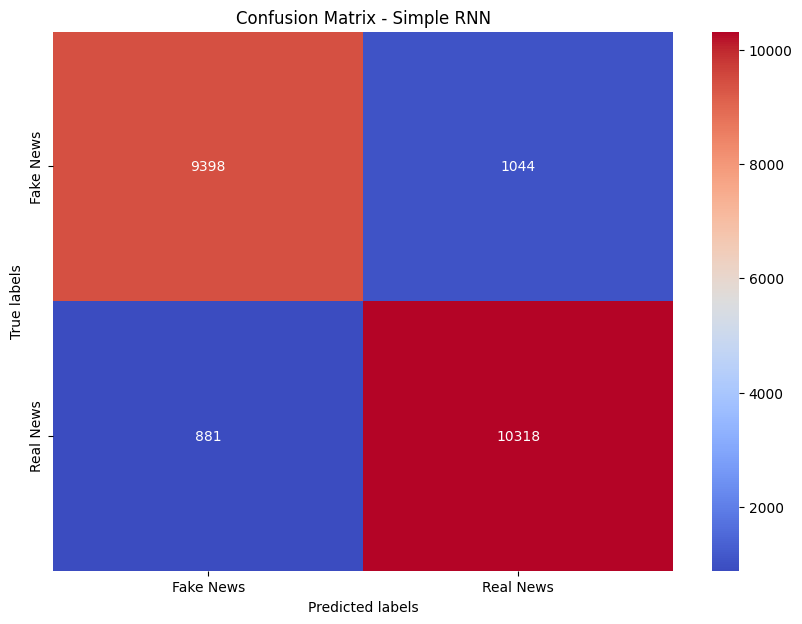

In [53]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=True)

# Set axis labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Simple RNN')

# Set custom tick labels
ax.xaxis.set_ticklabels(['Fake News', 'Real News'])
ax.yaxis.set_ticklabels(['Fake News', 'Real News'])

# Show the plot
plt.show()


### Analysis

Analysis:
	- The model correctly recognized 9398 ‘fake news’ items and correctly classified 10318 ‘real news’ items.
	- However, it made 1044 errors by classifying ‘fake news’ as ‘real news’.
	- 881 ‘real news’ was incorrectly classified as ‘fake news’.

Interpretation:

The number of false positives (881) and false negatives (1044) indicates that the model has room for improvement in reliably distinguishing ‘fake news’ from ‘real news’.

In [ ]:
# Save the model to a file
with open('trained_rnn_model_1.pkl', 'wb') as file:
    pickle.dump(rnn_model_1, file)

## LSTM (Long Short-Term Memory Networks)